### Karger's Algorithm w/ Union Find


The `Union-Find` data structure can be used to maintain a collection of disjoint sets a.k.a. `connected components`. This data structure supports the following operations:

1) `MakeUnionFind(S)`: Given a set of elements `S`, this operation initializes a collection of singleton components on the elements of `S`
2) `Find(u)`: Given an element u, this operation returns the connected component containing `u` 
3) `Union(A,B)`: Given two connected components `A` and `B`, this operation merges them into a single connected component.

##### Union-Find Pointer-based Implementation:

We define a `record` as an object that contains an element and a pointer. `MakeUnionFind(S)` creates a record for each element of $S$, each record represents a singleton connected component whose `label` is the `id` of the element it contains (element ids are integers in the range $[0,|S|-1]$). The pointers are initially set to null. These records are stored in a fixed size array indexed by the element `id`. A record with a null pointer corresponds to the element which labels a connected component.

We also create an array `Size[0:n-1]`, where $n=|S|$, which is filled with $1$. Thus the value `Size[i]` represents the the number of elements contained in the connected component with label `i`.

Given two connected components $A$ and $B$, let $u \in A$ and $v \in B$ be the records that label the respective components, also called the `root` records. Then to implement `Union(A,B)`, we first check `Size[u]` and `Size[v]`, then whichever component is smaller, we set the pointer of it's label record to point to the record labelling of the larger component, e.g. if `Size[u] > Size[v]`, then we set `record[v].pointer = record[u]`. This merges $B$ into $A$. Then we update the size of the larger component

Given an element whose id is `u`, the `Find(u)` operation first accesses the record containing that element, then follows the pointer back to the `root` record which labels the connected component containing element `u`. To optimize this operation, we can use the `path compression` technique. During each call to `Find(u)`, path compression involves simply updating the pointers of all records on the path from `u`, upto and excluding the root, to point directly to the root. So the next time we call `Find()` on any of these elements, their pointer will take us straight to the root instead of having to traverse over a long chain of records to get there.    


##### Implementing Karger Edge Contractions using Union-Find:

In Karger's algorithm, an edge contraction results in the merger of two vertices into a single super-vertex. We can implement this using a Union-Find data structure. Initially, each record contains a vertex. We also maintain a dynamic array, called the edge list, containing all the edges of the graph. Then given to contract an edge $(u,v)$, we first check if $u$ and $v$ are in the same connected component by comparing $Find(u)$ and $Find(v)$. If $Find(u) \neq Find(v)$, then we invoke a `Union()` on their respective connected components to merge the vertices and delete that edge from the edge list. Otherwise, if $Find(u) = Find(v)$, then we don't need to merge them, and only delete that edge from the edge list.

So, after performing $n-2$ `Union()` operations, we will be left with only two super-vertices. The edges remaining in the edge list will contain the edges corresponding to the cut in addition to edges that are within each connected component. So we need to scan through the edge list and remove the inter-component edges and then we will have remaining only the crossing edges of the cut. This approach is simpler and more efficient than the adjacency list approach that we previously implemented.


In [22]:
import networkx as nx
import matplotlib.pyplot as plt
import random
random.seed(0)


# record object to store the item id and the pointer to the parent record
class record():
    def __init__(self, id):
        self.id = id
        self.pointer =  None

    def update_pointer(self, pointer):
        self.pointer = pointer


# union find data structure
class UnionFind():
    def __init__(self):
        pass
    
    def makeUnionFind(self, S):    
        # S contains a list ids of n items from {0, 1, 2, 3, ...n-1}
        self.S = S
        # create records for each item
        self.records = [record(S[i]) for i in range(len(S))]
        self.Size = [1 for i in range(len(S))]

    # find the root of the component containing element with id u
    def find(self, u): 
        # follow the pointers back to root, store every record along the way in a list
        path = []
        while self.records[u].pointer:
            path.append(u)
            u = self.records[u].pointer.id
        root_id = u
        # path compression: reset the pointers of all the records in the path to the root
        for id in path:
            self.records[id].update_pointer(self.records[root_id])        
        return self.records[root_id]

    # merge the components with root records A and B    
    def union(self, A, B):
        # update the pointer of the root of the smaller component to the root of the larger component
        if self.Size[A.id] < self.Size[B.id]:
            self.records[A.id].update_pointer(self.records[B.id])
            self.Size[B.id] += self.Size[A.id]
            self.Size[A.id] = 0
        else:
            self.records[B.id].update_pointer(self.records[A.id])
            self.Size[A.id] += self.Size[B.id]
            self.Size[B.id] = 0    

    def __str__(self):
        # create dictionary of component lists
        component_dict = {i:[] for i in self.S}
        for i in range(len(self.S)):
            component_dict[self.find(self.S[i]).id].append(self.S[i]) 
        
        return str(component_dict)       


# create nice plot of a graph
def plot_graph(E, fig_size=5):
    # Create a new graph
    G = nx.Graph()

    # Add edges to the graph
    for (u, v) in E:
        G.add_edge(u, v)

    # Draw the graph
    plt.figure(figsize=(fig_size, fig_size))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    plt.show()             

In [27]:
class Edge:
    def __init__(self, u, v):
        self.u = u
        self.v = v

    def __str__(self):
        return str((self.u, self.v))

    def __repr__(self):
        return str((self.u, self.v))


def find_mincut(num_iters, G, verbose=False):
    min_cut_edges = None
    min_cut_size = float('inf')
    for i in range(num_iters):
        if verbose:
            print(f"\nKarger Iteration # {i+1}")
        cut_edges = karger(G, verbose=verbose)
        if len(cut_edges) < min_cut_size:
            min_cut_edges = cut_edges
            min_cut_size = len(cut_edges)
    return min_cut_edges


def print_vertices(vertices):
    print("\nConnected components:\n")
    print(vertices)
    
def print_edge_list(edge_list):
    print("\nEdge list:\n")
    for e in edge_list:
        print(f"({e.u}, {e.v})")


def karger(G, verbose=False):
    (V, E) = G  # V is a list of vertex ids (0,1,2,...,n-1) and E is a list of edges [(u,v), ...]

    # create UnionFind data structure on the vertices
    vertices = UnionFind()
    vertices.makeUnionFind(V)

    # create edge list
    edge_list = [Edge(u, v) for (u,v) in E]

    if verbose:
        print_vertices(vertices)
        print_edge_list(edge_list)
    
    # perform n-2 edge contractions
    i = 0
    while i < (len(V)-2):
        # remove an edge uniformly at random from the edge list
        idx = random.randint(0, len(edge_list)-1)
        edge = edge_list[idx]
        edge_list[idx] = edge_list[-1]
        edge_list.pop()

        #print(f"\nRandom edge selected: {edge}")
        # perform contraction on this edge
        i = contraction(edge, vertices, i, verbose)
        if verbose:
            print(f"Done contraction.")    
            print_vertices(vertices)
            print_edge_list(edge_list)


    # now scan the remaining edges to extract the crossing edges, i.e. edges that connect vertices from different connected components
    cut_edges = []
    for edge in edge_list:
        u, v = edge.u, edge.v
        A = vertices.find(u)
        B = vertices.find(v)
        if A.id != B.id:
           cut_edges.append(edge)
           
    # output remaining edges after contractions (use edge id to get the original edge label)
    cut_edges = [(e.u, e.v) for e in cut_edges]
    if verbose:
        print(f"\n Crossing-edges: {cut_edges}")
    
    return cut_edges


def contraction(edge, vertices, i, verbose):
    u, v = edge.u, edge.v

    if verbose:
        print(f"\nContracting edge ({edge.u},{edge.v})")

    # find the components containing u and v
    A = vertices.find(u)
    B = vertices.find(v)
    
    # merge if different connected components
    if A.id != B.id:
        if verbose:
            print(f"Components {A.id} and {B.id} are different. Merging them.")
        vertices.union(A, B)
        i += 1

    return i    

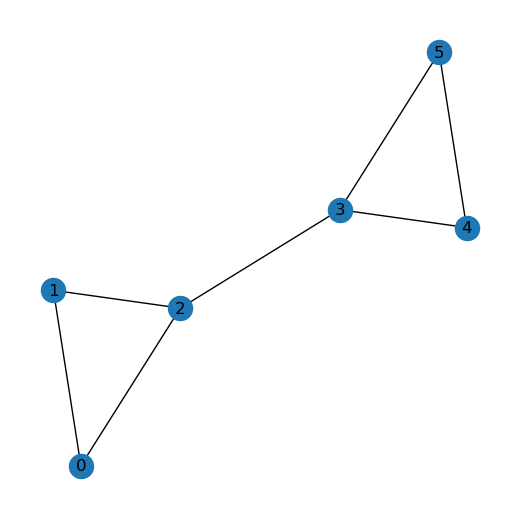

[(2, 3)]

In [31]:
# example graph
V = [0,1,2,3,4,5]
E = [(0,1), (0,2), (1,2), (2,3), (3,4), (3,5), (4,5)]
G = (V,E)

# plot the graph
plot_graph(E, fig_size=5)


# test karger
num_iters = 10
find_mincut(num_iters, G, verbose=False)


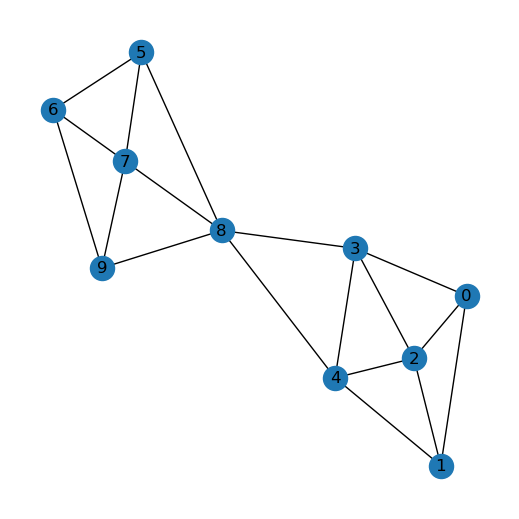

[(3, 8), (8, 4)]

In [32]:
# example graph
V = [0,1,2,3,4,5,6,7,8,9]
E = [(0,1),(1,2),(3,0),(4,1),(8,9),(0,2),(2,3),(8,4),(2,4),(4,3),(3,8),(8,5),(5,7),(8,7),(5,6),(6,7),(7,9),(9,6)]
G = (V,E)

# plot the graph
plot_graph(E, fig_size=5)


# test karger
num_iters = 20
find_mincut(num_iters, G, verbose=False)
